#Data Understanding

##Import Library

In [1]:
!pip install yfinance
import yfinance as yf

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor

##Load Dataset

In [2]:
df = yf.download("ADRO.JK", start="2020-01-01", end="2025-01-01")

# Ubah multi-level columns jadi single-level
df.columns = df.columns.get_level_values(0)


# Lihat hasilnya
df.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price            Close        High         Low        Open     Volume
Date                                                                 
2020-01-02  504.317871  524.558053  502.631189  524.558053   76612000
2020-01-03  516.834778  518.598719  502.723248  515.070837  117795600
2020-01-06  516.834778  534.474190  511.542954  513.306895   61423200
2020-01-07  543.293884  543.293884  515.070825  522.126590   74336500
2020-01-08  530.946350  541.529998  530.946350  539.766057   55121100

##EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1211 entries, 2020-01-02 to 2024-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1211 non-null   float64
 1   High    1211 non-null   float64
 2   Low     1211 non-null   float64
 3   Open    1211 non-null   float64
 4   Volume  1211 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 56.8 KB


Data Berisi type data numerik

In [4]:
df.describe()

Price        Close         High          Low         Open        Volume
count  1211.000000  1211.000000  1211.000000  1211.000000  1.211000e+03
mean   1100.609613  1119.804648  1083.563543  1101.912415  9.020292e+07
std     584.763769   593.280354   577.015894   585.095993  7.651315e+07
min     227.548431   236.368138   215.200827   227.548416  0.000000e+00
25%     480.139526   490.097762   473.672987   484.013315  4.325485e+07
50%    1243.882812  1266.508158  1224.569491  1243.882822  7.060990e+07
75%    1480.981262  1498.126749  1454.704788  1473.816567  1.087420e+08
max    2644.297363  2759.266741  2644.297363  2644.297363  1.047877e+09

Terlihat data volume memiliki nilai minimum 0 yang seharusnya tidak ada.

###Drop Missing Value

In [5]:
volume = (df.Volume == 0).sum()
print(volume)

1


In [6]:
df.loc[(df['Volume']==0)]

Price           Close       High        Low       Open  Volume
Date                                                          
2020-03-16  292.81424  292.81424  292.81424  292.81424       0

In [7]:
# Drop baris dengan nilai 'Volume' = 0
df = df.loc[(df[['Volume']]!=0).all(axis=1)]

# Cek ukuran data untuk memastikan baris sudah di-drop
df.shape

(1210, 5)

Penghapusan data yang bernilai 0

In [8]:
df.describe()

Price        Close         High          Low         Open        Volume
count  1210.000000  1210.000000  1210.000000  1210.000000  1.210000e+03
mean   1101.277212  1120.488111  1084.217055  1102.581091  9.027746e+07
std     584.543690   593.048532   576.805959   584.874823  7.650078e+07
min     227.548431   236.368138   215.200827   227.548416  1.241340e+07
25%     480.493645   490.618863   474.331392   484.014925  4.331902e+07
50%    1243.882812  1267.739266  1225.953707  1243.882827  7.068465e+07
75%    1481.142853  1498.795868  1454.704826  1474.979891  1.087770e+08
max    2644.297363  2759.266741  2644.297363  2644.297363  1.047877e+09

###Mengatasi Outliers

In [9]:
# Buat plot untuk semua kolom numerik
numerical_cols = ['Open', 'High', 'Low', 'Close', 'Volume']

plt.figure(figsize=(15, 8))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 3, i+1)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

Hasil Visual BoxPlot memperlihatkan bahwa bagian Volume memiliki Outliers

In [10]:
# Hitung Q1, Q3, dan IQR khusus untuk kolom 'Volume'
Q1 = df['Volume'].quantile(0.25)
Q3 = df['Volume'].quantile(0.75)
IQR = Q3 - Q1

# Buat filter untuk mendeteksi data yang tidak outlier
filter_outliers = ~((df['Volume'] < (Q1 - 1.5 * IQR)) | (df['Volume'] > (Q3 + 1.5 * IQR)))

# Terapkan filter ke seluruh dataset
df_cleaned = df[filter_outliers]

# Cek ukuran dataset setelah outlier Volume dihapus
print(df_cleaned.shape)


(1133, 5)


Data Volume yang bernilai outlier dihapus agar data bisa di proses lebih lanjut.

###Univariate Analysis

In [11]:
# Kolom numerik
numerical_cols = df_cleaned.select_dtypes(include=['int64', 'float64']).columns

# Kolom kategorikal (termasuk object dan datetime)
categorical_cols = df_cleaned.select_dtypes(include=['object', 'category', 'datetime']).columns

print("Fitur numerik:", list(numerical_cols))
print("Fitur kategorikal:", list(categorical_cols))


Fitur numerik: ['Close', 'High', 'Low', 'Open', 'Volume']
Fitur kategorikal: []


Karena data bertype numerik semua, sehingga tidak ada analisis Category

####Numerical Features

In [12]:
df.hist(bins=50, figsize=(20,15))
plt.show()

###Multivariate Analysis

####Numerical Features

In [13]:
# Mengamati hubungan antar fitur numerik dengan fungsi pairplot()
sns.pairplot(df, diag_kind = 'kde')

Text(0.5, 1.0, 'Correlation Matrix untuk Fitur Numerik ')

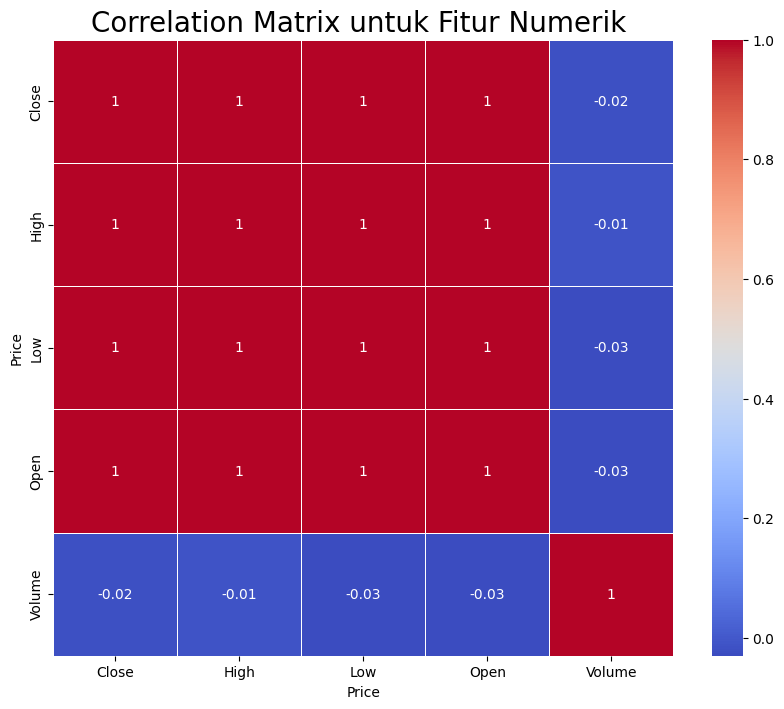

In [14]:
plt.figure(figsize=(10, 8))
correlation_matrix = df[numerical_cols].corr().round(2)

# Untuk menge-print nilai di dalam kotak, gunakan parameter anot=True
sns.heatmap(data=correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, )
plt.title("Correlation Matrix untuk Fitur Numerik ", size=20)

Dari hasil Correlation Matrix menunjukkan bahwa Volume jauh dari korelasi, sehingga akan dibuang.

In [15]:
df.drop(['Volume'], inplace=True, axis=1)
df.head()

Price            Close        High         Low        Open
Date                                                      
2020-01-02  504.317871  524.558053  502.631189  524.558053
2020-01-03  516.834778  518.598719  502.723248  515.070837
2020-01-06  516.834778  534.474190  511.542954  513.306895
2020-01-07  543.293884  543.293884  515.070825  522.126590
2020-01-08  530.946350  541.529998  530.946350  539.766057

#Data Preparation

##Reduksi Dimensi Dengan PCA

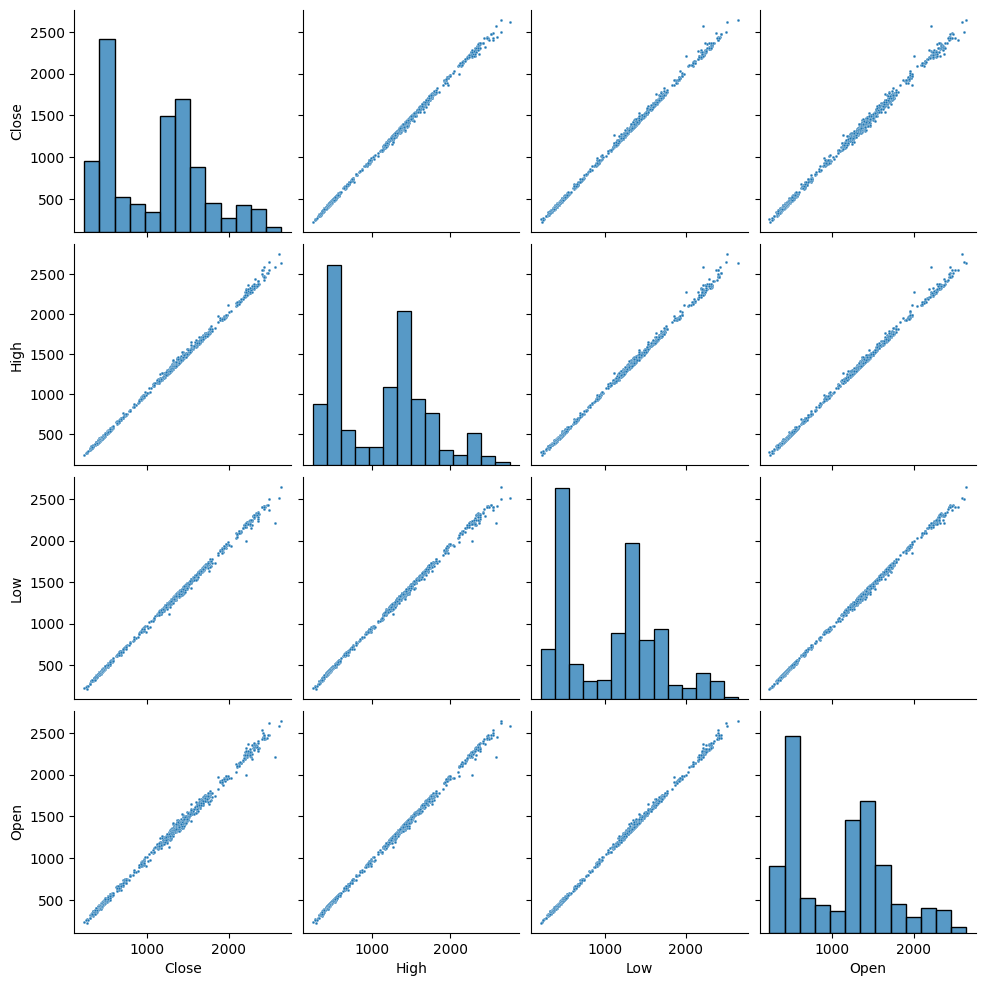

In [16]:
sns.pairplot(df[['Close','High','Low','Open']], plot_kws={"s": 4});

In [17]:
# Ambil fitur
features = ['Close', 'High', 'Low', 'Open']
X = df[features]

# Standardisasi
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA setelah standardisasi
pca = PCA(n_components=4, random_state=123)
princ_comp = pca.fit_transform(X_scaled)


In [18]:
pca.explained_variance_ratio_.round(5)

array([9.995e-01, 3.100e-04, 1.600e-04, 3.000e-05])

##Train Test Split

In [19]:
# Misalnya df adalah DataFrame kamu
X = df[['Open', 'High', 'Low']]  # fitur (tanpa 'Close')
y = df['Close']  # target

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.1,      # 10% data untuk pengujian
    random_state=123    # supaya split-nya konsisten
)


Split Data: 90:10

Fitur: Open, High, Low
Target: Close

In [20]:
print(f'Total # of sample in whole dataset: {len(X)}')
print(f'Total # of sample in train dataset: {len(X_train)}')
print(f'Total # of sample in test dataset: {len(X_test)}')

Total # of sample in whole dataset: 1210
Total # of sample in train dataset: 1089
Total # of sample in test dataset: 121


##Standarisasi

In [21]:
numerical_cols = ['Open', 'High', 'Low']
scaler = StandardScaler()
scaler.fit(X_train[numerical_cols])
X_train[numerical_cols] = scaler.transform(X_train.loc[:, numerical_cols])
X_train[numerical_cols].head()

Price           Open      High       Low
Date                                    
2024-08-15  1.417839  1.367247  1.417658
2021-02-25 -1.140466 -1.145859 -1.131292
2022-05-25  0.451212  0.414211  0.421754
2022-11-15  0.740070  0.713612  0.729745
2020-11-30 -1.015665 -0.985899 -1.064840

In [22]:
X_train[numerical_cols].describe().round(4)

Price       Open       High        Low
count  1089.0000  1089.0000  1089.0000
mean     -0.0000    -0.0000    -0.0000
std       1.0005     1.0005     1.0005
min      -1.5020    -1.4968    -1.5130
25%      -1.0590    -1.0683    -1.0648
50%       0.2363     0.2472     0.2447
75%       0.6339     0.6267     0.6278
max       2.6107     2.7363     2.6796

#Model Deployment

In [23]:
# Siapkan dataframe untuk analisis model
models = pd.DataFrame(index=['train_mse', 'test_mse'],
                      columns=['KNN', 'RandomForest', 'Boosting'])


Analisis Model akan menggunakan tiga jenis model, yaitu:

KNN, RandomForest, Boosting

##KNN

In [24]:
knn = KNeighborsRegressor(n_neighbors=10)
knn.fit(X_train, y_train)

models.loc['train_mse','knn'] = mean_squared_error(y_pred = knn.predict(X_train), y_true=y_train)

##Random Forest

In [25]:
# buat model prediksi
RF = RandomForestRegressor(n_estimators=50, max_depth=16, random_state=55, n_jobs=-1)
RF.fit(X_train, y_train)

models.loc['train_mse','RandomForest'] = mean_squared_error(y_pred=RF.predict(X_train), y_true=y_train)

##Metode Adaptive Boosting

In [26]:
boosting = AdaBoostRegressor(learning_rate=0.05, random_state=55)
boosting.fit(X_train, y_train)
models.loc['train_mse','Boosting'] = mean_squared_error(y_pred=boosting.predict(X_train), y_true=y_train)

##Scaling Pada Data Uji

In [27]:
# Lakukan scaling terhadap fitur numerik pada X_test sehingga memiliki rata-rata=0 dan varians=1
X_test.loc[:, numerical_cols] = scaler.transform(X_test[numerical_cols])

#Evaluasi Model

In [28]:
# Buat variabel mse yang isinya adalah dataframe nilai mse data train dan test pada masing-masing algoritma
mse = pd.DataFrame(columns=['train', 'test'], index=['KNN','RF','Boosting'])

# Buat dictionary untuk setiap algoritma yang digunakan
model_dict = {'KNN': knn, 'RF': RF, 'Boosting': boosting}

# Hitung Mean Squared Error masing-masing algoritma pada data train dan test
for name, model in model_dict.items():
    mse.loc[name, 'train'] = mean_squared_error(y_true=y_train, y_pred=model.predict(X_train))/1e3
    mse.loc[name, 'test'] = mean_squared_error(y_true=y_test, y_pred=model.predict(X_test))/1e3

# Panggil mse
mse

train      test
KNN       0.269312  0.223928
RF        0.046941  0.200953
Boosting  5.420234  4.499796

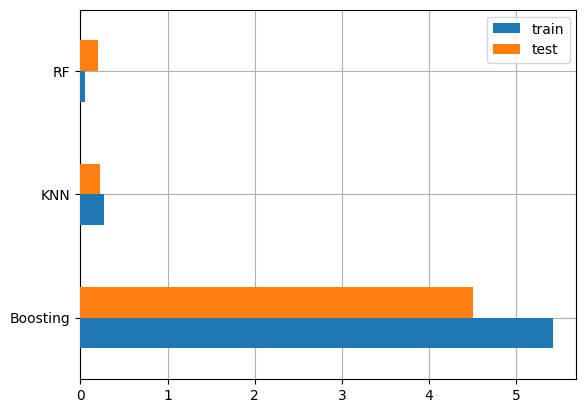

In [29]:
fig, ax = plt.subplots()
mse.sort_values(by='test', ascending=False).plot(kind='barh', ax=ax, zorder=3)
ax.grid(zorder=0)

Penjelasan:

- Boosting	~5.4	~4.4	Overfitting terlihat → error train & test cukup besar tapi tidak seimbang. Boosting cenderung fit terlalu dalam ke data latih.
- KNN	~0.26	~0.22	Cukup stabil → train dan test error mirip → model tidak overfit atau underfit.
- RF	~0.04	~0.2	Sangat baik → performa sangat bagus di train dan cukup baik di test. Hampir tidak overfit.



##Uji Data

In [30]:
prediksi = X_test.iloc[:1].copy()
pred_dict = {'y_true':y_test[:1]}
for name, model in model_dict.items():
    pred_dict['prediksi_'+name] = model.predict(prediksi).round(1)

pd.DataFrame(pred_dict)

y_true  prediksi_KNN  prediksi_RF  prediksi_Boosting
Date                                                                 
2023-12-27  1336.786865        1339.1       1337.5             1304.0

Evaluasi Akurasi Prediksi:

Hasil Asli = 1336.7
- KNN	1339.1 	 ->	Cukup dekat
- RandomForest	1337.5	 ->	Paling akurat
- Boosting	1304.0	 ->	Jauh lebih rendah dari aslinya

###Kesimpulan:
- Semua model cukup baik kali ini, terutama Random Forest yang prediksinya hampir identik dengan nilai sebenarnya.

- Model Boosting cenderung underestimate (meremehkan nilai).

- KNN juga cukup akurat, hanya sedikit lebih tinggi.